In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


## Loading the MNIST dataset

In [3]:
train_ds = datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [4]:
batch_size = 64
#batch_size = 5 # for testing
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

## Looking at the data

In [5]:
train_dl = iter(train_loader)
x, y = next(train_dl)

Process Process-1:
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [6]:
print(x.shape, y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [7]:
def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [8]:
# first from torch to numpy
X = x.numpy(); Y = y.numpy()
X.shape

(64, 1, 28, 28)

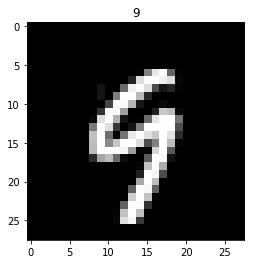

In [9]:
show(X[0][0], Y[0])

## Create NN model skeleton 

In [5]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    model.train()
    sum_loss = 0.0
    total = 0
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = Variable(images.view(-1, 28*28)).cuda() #sending to GPU
            labels = Variable(labels).cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels) #torch.nn.functional all these can be called as F
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.data[0]
            #if (i+1) % 100 == 0:
                #print ('Epoch [%d/%d], Loss: %.4f' 
                 #  %(epoch+1, num_epochs, sum_loss/total))
                
        train_loss = sum_loss/total
        #print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        #print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [6]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = Variable(images.view(-1, 28*28)).cuda()
        labels = Variable(labels).cuda()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.data[0]
        total += labels.size(0)
        correct += pred.eq(labels.data).cpu().sum()
    return 100 * correct / total, sum_loss/ total

In [7]:
# for the number of neurons in the hidden unit
def get_model(M = 300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, 10))
    return net.cuda()
# last is M, 10, ten digits
# input is 28*28 input 

## Part 1. Tune the learning rate

In [13]:
learning_rate = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

In [14]:
for lr in learning_rate:
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    model_accuracy_loss(net, test_loader)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    print("val_acc:",val_acc,"val_loss:", val_loss,"train_loss:",train_loss)

val_acc: 11.71 val_loss: 2.4993606101989747 train_loss: 15.69046331932068
val_acc: 10.3 val_loss: 2.3068014167785647 train_loss: 2.346710188153585
val_acc: 94.95 val_loss: 0.2701721287965774 train_loss: 0.18489152574996154
val_acc: 97.93 val_loss: 0.08764553509950637 train_loss: 0.0554013519248118
val_acc: 97.58 val_loss: 0.07912932171821595 train_loss: 0.1581827309225003
val_acc: 92.7 val_loss: 0.2543579046726227 train_loss: 0.46689417521476745


From the result above, we can see from both validation accuracy and validation loss point of view, 0.01 and 0.001 learning rate yield top 2 results. I will interpolate between these two value 

In [17]:
learning_rate2 = [0.01,0.004,0.008, 0.001]

In [18]:
for lr in learning_rate2:
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    model_accuracy_loss(net, test_loader)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    print("lr:", lr,"val_acc:",val_acc,"val_loss:",val_loss)

lr: 0.01 val_acc: 95.39 val_loss: 0.23787590246200563
lr: 0.004 val_acc: 96.82 val_loss: 0.19191578224599362
lr: 0.008 val_acc: 95.91 val_loss: 0.23701444540023803
lr: 0.001 val_acc: 98.11 val_loss: 0.0758550889492035


*OBSERVATION:*: 

The best validation accuracy is when learning rate is 0.001. From the experiment in the last round, we can see that compared to 0.01, 0.001 yields smaller training and validation loss so overfitting is not a problem. 

## Part 2. Tune the hidden layer size

In [8]:
layer_size = [10, 50, 100, 300, 1000, 2000]

In [9]:
for s in layer_size:
    net = get_model(M = s )
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    model_accuracy_loss(net, test_loader)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    print("layer_size:", s, "val_acc:",val_acc,"val_loss:", val_loss,"train_loss:",train_loss)

layer_size: 10 val_acc: 90.03 val_loss: 0.33734149022102355 train_loss: 0.3717853285161654
layer_size: 50 val_acc: 95.07 val_loss: 0.22485833089351653 train_loss: 0.193383240087231
layer_size: 100 val_acc: 94.76 val_loss: 0.27137517743110656 train_loss: 0.1831809880844752
layer_size: 300 val_acc: 95.1 val_loss: 0.2450180930495262 train_loss: 0.1829553218181928
layer_size: 1000 val_acc: 95.25 val_loss: 0.2694191605567932 train_loss: 0.19047950228353341
layer_size: 2000 val_acc: 95.47 val_loss: 0.25217795172929763 train_loss: 0.1887618602490425


*OBSERVATION:*

the layer size that yielded the best accuracy is 2000. Overfitting start to show up beyond layer size of 50 because validation loss reached the minimum at 0.22 and start to increase since that. 

## Part 3. Tune the L2 regularization weight

In [10]:
weight_decay = [0, 0.0001, 0.001, 0.01, 0.1, 0.3]

In [11]:
for wd in weight_decay:
    net = get_model(M = 300 )
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay =wd)
    model_accuracy_loss(net, test_loader)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    print("weight decay:", wd, "val_acc:",val_acc,"val_loss:", val_loss,"train_loss:",train_loss)


weight decay: 0 val_acc: 98.03 val_loss: 0.12329273672103881 train_loss: 0.03379573976036161
weight decay: 0.0001 val_acc: 97.75 val_loss: 0.0767269659459591 train_loss: 0.039960156274487575
weight decay: 0.001 val_acc: 98.03 val_loss: 0.06791373198032379 train_loss: 0.0709504307956497
weight decay: 0.01 val_acc: 96.37 val_loss: 0.1430223176717758 train_loss: 0.16924466012020906
weight decay: 0.1 val_acc: 89.77 val_loss: 0.44151821737289426 train_loss: 0.47092641704559324
weight decay: 0.3 val_acc: 85.09 val_loss: 0.7888756879806519 train_loss: 0.819635253944397


## Part 4. models with dropout

In [27]:
def get_model_v2(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules).cuda()

In [28]:
plist = [0,0.3,0.5,0.7,1]

In [29]:
for p in plist:
    net = get_model_v2(M = 300, p=p)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    val_acc, val_loss, train_loss=train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    print("dropout rate:", p, "val_acc:",val_acc,"val_loss:", val_loss,"train_loss:",train_loss)

dropout rate: 0 val_acc: 97.93 val_loss: 0.11732124398350716 train_loss: 0.033310068961158394
dropout rate: 0.3 val_acc: 97.99 val_loss: 0.12572206707298755 train_loss: 0.03589762788457175
dropout rate: 0.5 val_acc: 97.97 val_loss: 0.1145123995423317 train_loss: 0.039802622276532154
dropout rate: 0.7 val_acc: 97.88 val_loss: 0.13438771730959415 train_loss: 0.04717220964011426
dropout rate: 1 val_acc: 97.84 val_loss: 0.11502244354486466 train_loss: 0.14324818946938342


*OBSERVATION:*

If we use accuracy to measure the model performance, the best performance is achieved when dropout ratio equals 0.3. At this small ratio, a small portion of the nerons were zeroed out so that most nerons still functioned to make the prediction.

With dropout method, the model generally resulted a higher validation accuracy so we can conclude that dropout help to increase testing accuracy. 

## Part 5. 3-layer model 

In [34]:
def get_model_v3(M1 = 30, M2 = 40, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M1))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M1, M2))
    modules.append(nn.Linear(M2, 10))
    return nn.Sequential(*modules).cuda()

In [ ]:
L2_weight = [0, 0.3]
plist =[0,0.3,1]
lr_list = [0.1,0.001]
for wd in L2_weight:
    for p in plist:
        for lr in lr_list:
            net = get_model_v3(p=p)
            optimizer = optim.Adam(net.parameters(), lr=lr,weight_decay =wd)
            val_acc, val_loss, train_loss=train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
            print("dropout rate:", p, "weight:", wd,"learning rate:", lr,"val_loss:", val_loss,"train_loss:",train_loss)

dropout rate: 0 weight: 0 learning rate: 0.1 val_loss: 2.3913672847747804 train_loss: 2.3381452978960673
dropout rate: 0 weight: 0 learning rate: 0.001 val_loss: 0.14729523298740388 train_loss: 0.08845896285573641
dropout rate: 0.3 weight: 0 learning rate: 0.1 val_loss: 2.3756185348510743 train_loss: 2.3319020805040993
dropout rate: 0.3 weight: 0 learning rate: 0.001 val_loss: 0.15349675698280335 train_loss: 0.10694206710656484
dropout rate: 1 weight: 0 learning rate: 0.1 val_loss: 2.3436830627441405 train_loss: 2.506178075358073
dropout rate: 1 weight: 0 learning rate: 0.001 val_loss: 0.13687180075645447 train_loss: 0.20962918531278768
dropout rate: 0 weight: 0.3 learning rate: 0.1 val_loss: 1.5694501695632934 train_loss: 2.796901769323349
dropout rate: 0 weight: 0.3 learning rate: 0.001 val_loss: 1.1922107063293457 train_loss: 1.2018240967877707
dropout rate: 0.3 weight: 0.3 learning rate: 0.1 val_loss: 1.4958884099960328 train_loss: 2.7230308541742962


*OBSERVATION*

To avoid overfitting in the parameter grid search process, I decided to use validation loss to assess the performance of the models. The smallest validation loss is 0.13 when dropout rate is 1, weight is 0 (no regularization) and learning rate is 0.001.